## Identify fraudulent credit card transactions.
Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import time
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, precision_score 
from sklearn.metrics import recall_score, average_precision_score, auc

import imblearn
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

Using TensorFlow backend.


In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## About Dataset
- 492 frauds out of 284,807 transactions;
- Highly unbalanced, the positive class (frauds) account for 0.172% of all transactions
- Contains only numerical input variables which are the result of a PCA transformation
- Only features which have not been transformed with PCA are 'Time' and 'Amount'; 
- Feature 'Time' = seconds elapsed between each transaction and the first transaction in the dataset; <br> Feature 'Amount' = transaction Amount, this feature can be used for example-dependant cost-senstive learning. <br> Feature 'Class' = response variable; 1=fraud and 0=otherwise.


In [4]:
data = pd.read_csv('../input/creditcardfraud/creditcard.csv')
df = data.copy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


---------------

In [5]:
def plot_pr_curve(precision, recall, label=None):
    plt.figure(figsize=(8, 6)) 
    plt.plot(recall, precision, linewidth=2, label=label, color='red')
    plt.axis([0, 1, 0, 1])
    plt.title('Precision vs. Recall Curve', fontsize=18)
    plt.xlabel('True Positive Rate (Recall)', fontsize=16) 
    plt.ylabel('Precision)', fontsize=16)    
    plt.grid(True) 
    plt.show()

In [6]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6)) 
    plt.plot(fpr, tpr, linewidth=2, label=label, color='red')
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.title('Receiver Operating Curve(ROC)', fontsize=18)
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    #plt.legend(True)
    plt.grid(True)
    plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [23]:
def metrics(y_test, ypred):
    recall = recall_score(y_test, ypred)
    precis = precision_score(y_test, ypred)
    f1 = f1_score(y_test, ypred)
    auroc = roc_auc_score(y_test, ypred)
    avg_precis = average_precision_score(y_test, ypred)
    print("Recall score: "+str(recall))
    print("Precision score: "+str(precis))
    print("F1 score: "+str(f1))
    print("AUROC: "+str(auroc))
    print("Average Precision score: "+str(avg_precis))

-----------
# EDA

In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


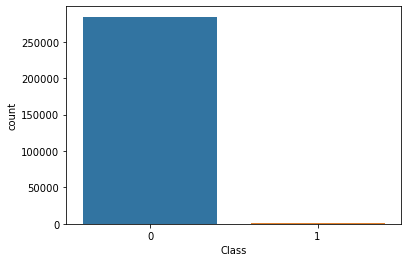

In [10]:
sns.countplot(df['Class'])

--------------------
# Data pre-processing

In [11]:
df['norm_amount'] = StandardScaler().fit_transform(np.array(df['Amount']).reshape(-1,1))
df['norm_time'] = StandardScaler().fit_transform(np.array(df['Time']).reshape(-1,1))

In [12]:
df.drop(['Time','Amount'], axis=1, inplace=True)

In [13]:
X = df.copy()
X.drop(['Class'], axis=1, inplace=True)
y = df.loc[:,'Class']

## Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
print("Training data count of 0={}, count of 1={}".format(sum(y_train==0), sum(y_train==1)))
print("Testing data count of 0={}, count of 1={}".format(sum(y_test==0), sum(y_test==1)))

Training data count of 0=227454, count of 1=391
Testing data count of 0=56861, count of 1=101


----------------
# LightGBM

In [16]:
classifier = lgb.LGBMClassifier(objective='binary', random_state=0, n_jobs=-1)#,max_bin=128)
print(classifier)
rs_parameters = {
    'lgbmclassifier__learning_rate': [0.005,0.01,0.001,0.05],
    'lgbmclassifier__n_estimators': [20,40,60,80,100],
    'lgbmclassifier__num_leaves': [6,8,12,16]
    }

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


------------
# Testing w. imbalanced data 

In [24]:
classifier.fit(X_train, y_train)
print(np.mean(cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc')))
ypred = classifier.predict(X_test)
metrics(y_test, ypred)

0.6858523119218958
Recall score: 0.6138613861386139
Precision score: 0.27555555555555555
F1 score: 0.38036809815950917
AUROC: 0.805497373219146
Average Precision score: 0.16983758226249224


AUPRC: 0.4450508043325663


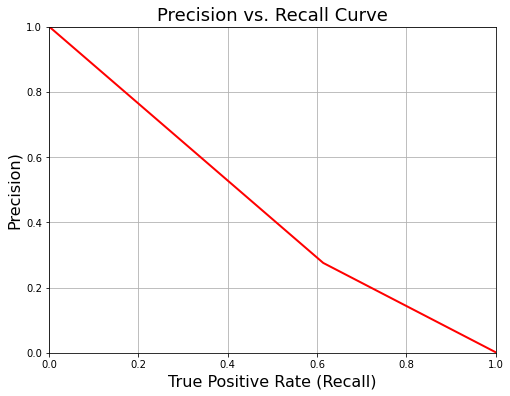

In [31]:
precis, recall,_ = precision_recall_curve(y_test, ypred)
print("AUPRC: "+str(auc(recall, precis)))
plot_pr_curve(precis, recall)

TP:62, TN:56698, FP:163, FN:39


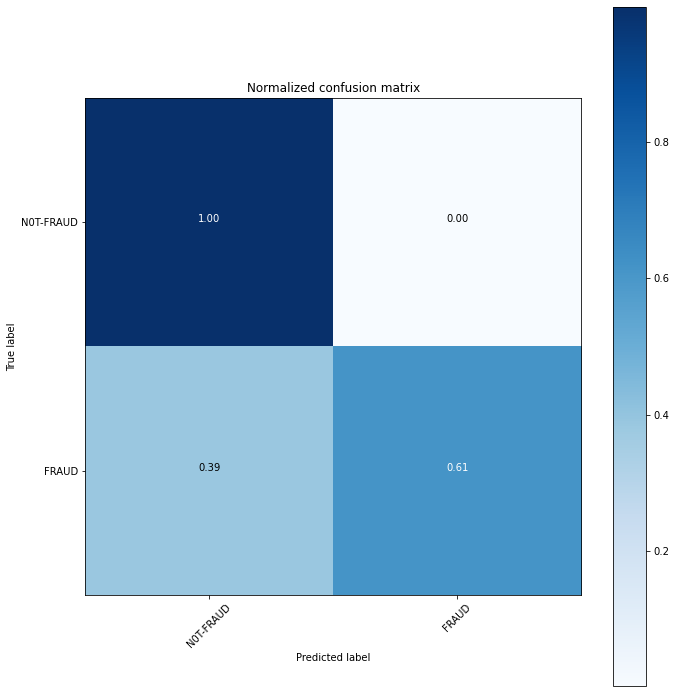

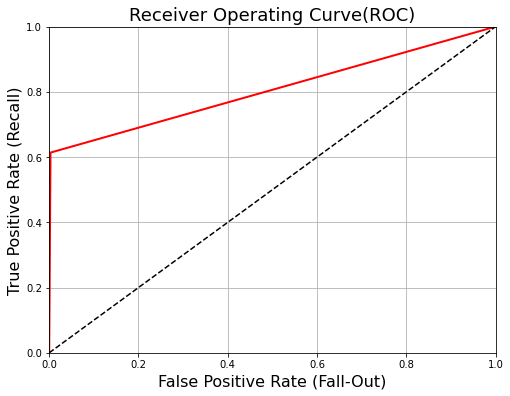

In [33]:
cnf_matrix = confusion_matrix(y_test, ypred)
print("TP:{}, TN:{}, FP:{}, FN:{}".format(cnf_matrix[1][1], cnf_matrix[0][0], cnf_matrix[0][1], cnf_matrix[1][0]))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["N0T-FRAUD","FRAUD"], title='Normalized confusion matrix')

fpr, tpr, thresholds = roc_curve(y_test, ypred) 
plot_roc_curve(fpr, tpr)

---------------------
# Resampling to solve imbalanced data

In [28]:
kf = KFold(n_splits=10, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0)

In [34]:
smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kf,
                         scoring='roc_auc',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train, y_train)
bestimator = grid_imba.best_estimator_
ypred = bestimator.predict(X_test)

print("Sampler: ",sampler)
print("Best estimator: ",bestimator)
print("Best cv score: ",grid_imba.best_score_)
metrics(y_test, ypred)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 36.4min finished


Sampler:  SMOTE(k_neighbors=5, n_jobs=None, random_state=0, sampling_strategy='auto')
Best estimator:  Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=0,
                       sampling_strategy='auto')),
                ('lgbmclassifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.05, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=12, objective='binary',
                                random_state=0, reg_alpha=0.0, reg_lambda=0.0,
                                silent=True, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)
Best cv sc

AUPRC: 0.5200212753431709


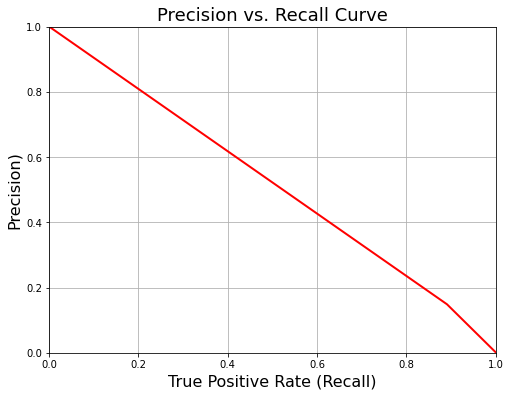

In [35]:
precis, recall,_ = precision_recall_curve(y_test, ypred)
print("AUPRC: "+str(auc(recall, precis)))   
plot_pr_curve(precis, recall)

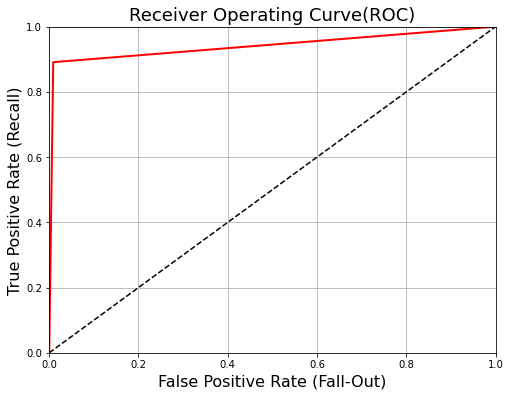

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, ypred) 
plot_roc_curve(fpr, tpr)

TP:90, TN:56346, FP:515, FN:11


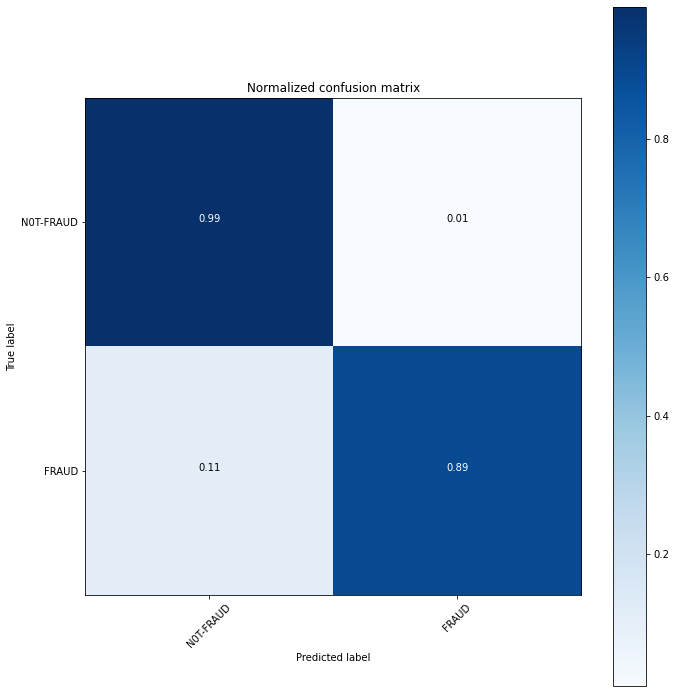

In [37]:
cnf_matrix = confusion_matrix(y_test, ypred)
print("TP:{}, TN:{}, FP:{}, FN:{}".format(cnf_matrix[1][1], cnf_matrix[0][0], cnf_matrix[0][1], cnf_matrix[1][0]))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["N0T-FRAUD","FRAUD"], title='Normalized confusion matrix')

----------------
### Connect and save at jovian.ml

In [38]:
!pip install jovian --upgrade --quiet
import jovian

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project='Credit-Fraud-pub-kaggle')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/babyyawlwi/Credit-Fraud-pub-kaggle


<IPython.core.display.Javascript object>